<a href="https://colab.research.google.com/github/Hemanthtak2000/22073706_Project_UoH/blob/main/22073706_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
Ins_Details_path = '/content/drive/My Drive/aug_train.csv'
Ins_Details = pd.read_csv(Ins_Details_path)
print(Ins_Details.head())

       id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  167647    Male   22                1          7.0                   1   
1   17163    Male   42                1         28.0                   0   
2   32023  Female   66                1         33.0                   0   
3   87447  Female   22                1         33.0                   0   
4  501933    Male   28                1         46.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    < 1 Year             No          2630.0                 152.0       16   
1    1-2 Year            Yes         43327.0                  26.0      135   
2    1-2 Year            Yes         35841.0                 124.0      253   
3    < 1 Year             No         27645.0                 152.0       69   
4    < 1 Year             No         29023.0                 152.0      211   

   Response  
0         0  
1         0  
2         0  
3         0 

In [ ]:
Ins_Details.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
Ins_Details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [ ]:
Ins_Details['Gender'] = Ins_Details['Gender'].astype('category')
Ins_Details['Vehicle_Age'] = Ins_Details['Vehicle_Age'].astype('category')
Ins_Details['Vehicle_Damage'] = Ins_Details['Vehicle_Damage'].astype('category')

In [ ]:
Ins_Details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    382154 non-null  int64   
 1   Gender                382154 non-null  category
 2   Age                   382154 non-null  int64   
 3   Driving_License       382154 non-null  int64   
 4   Region_Code           382154 non-null  float64 
 5   Previously_Insured    382154 non-null  int64   
 6   Vehicle_Age           382154 non-null  category
 7   Vehicle_Damage        382154 non-null  category
 8   Annual_Premium        382154 non-null  float64 
 9   Policy_Sales_Channel  382154 non-null  float64 
 10  Vintage               382154 non-null  int64   
 11  Response              382154 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 27.3 MB


In [ ]:
# Check for duplicates
Dup_Ins_Dtls = Ins_Details.duplicated()

# Display the number of duplicate rows
Total_Ins_Dup = Dup_Ins_Dtls.sum()
print(f'Number of duplicate rows: {Total_Ins_Dup}')

Number of duplicate rows: 0


In [ ]:
Ins_Details_PP = pd.get_dummies(Ins_Details, columns=['Gender', 'Vehicle_Age', 'Vehicle_Damage'], drop_first=True)
print(Ins_Details_PP.head())

       id  Age  Driving_License  Region_Code  Previously_Insured  \
0  167647   22                1          7.0                   1   
1   17163   42                1         28.0                   0   
2   32023   66                1         33.0                   0   
3   87447   22                1         33.0                   0   
4  501933   28                1         46.0                   1   

   Annual_Premium  Policy_Sales_Channel  Vintage  Response  Gender_Male  \
0          2630.0                 152.0       16         0         True   
1         43327.0                  26.0      135         0         True   
2         35841.0                 124.0      253         0        False   
3         27645.0                 152.0       69         0        False   
4         29023.0                 152.0      211         0         True   

   Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years  Vehicle_Damage_Yes  
0                  True                  False               False  
1 

In [ ]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in the 'Annual_Premium' column
Out_Det_Ann_Pre = detect_outliers_iqr(Ins_Details_PP, 'Annual_Premium')

# Display the number of outliers and the outlier rows
Count_Outliers = Out_Det_Ann_Pre.shape[0]
print(f'Number of outliers in Annual_Premium: {Count_Outliers}')
print(Out_Det_Ann_Pre)


Number of outliers in Annual_Premium: 10407
            id  Age  Driving_License  Region_Code  Previously_Insured  \
10       31460   25                1          8.0                   1   
45      373877   58                1         28.0                   0   
49      303609   22                1          8.0                   0   
50       54431   48                1         28.0                   0   
101     395073   65                1         28.0                   1   
...        ...  ...              ...          ...                 ...   
382075  461373   47                1         28.0                   0   
382089  241754   66                1         28.0                   0   
382106  143075   46                1          8.0                   0   
382120  201301   48                1          8.0                   1   
382150  247064   27                1         28.0                   1   

        Annual_Premium  Policy_Sales_Channel  Vintage  Response  Gender_Male  \

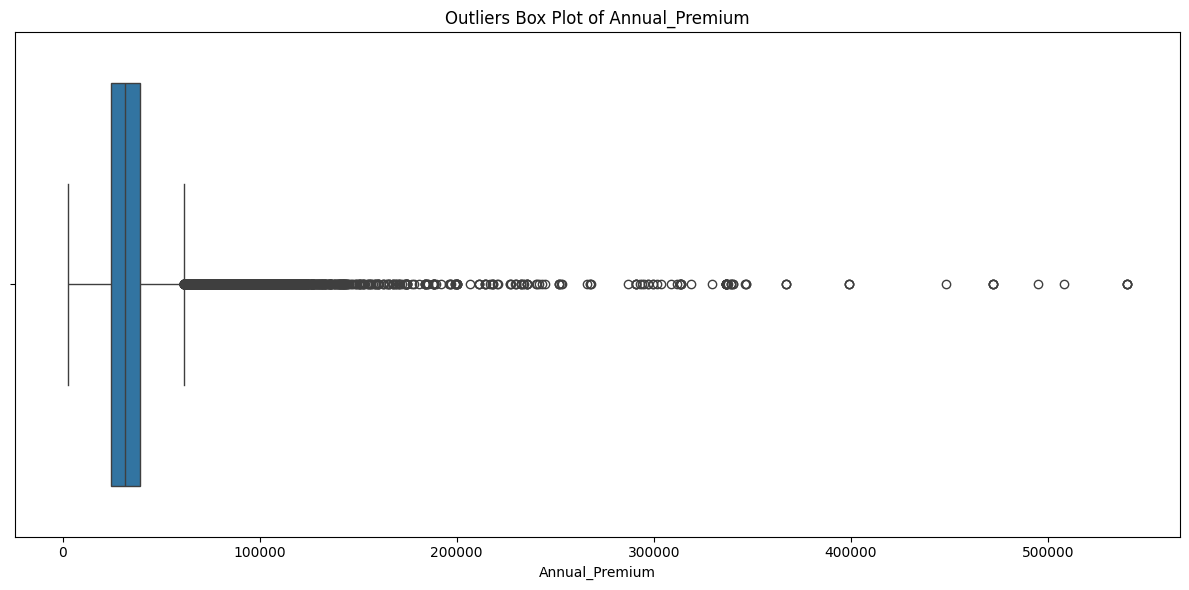

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x=Ins_Details_PP['Annual_Premium'])
plt.title('Outliers Box Plot of Annual_Premium')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the IQR bounds
Q1 = Ins_Details_PP['Annual_Premium'].quantile(0.25)
Q3 = Ins_Details_PP['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only values within the bounds
Ins_Details_PP_OL = Ins_Details_PP[(Ins_Details_PP['Annual_Premium'] >= lower_bound) & (Ins_Details_PP['Annual_Premium'] <= upper_bound)]

# Display the new DataFrame shape after outlier removal
print(f'Original DataFrame shape: {Ins_Details_PP.shape}')
print(f'DataFrame shape after outlier removal: {Ins_Details_PP_OL.shape}')


Original DataFrame shape: (382154, 13)
DataFrame shape after outlier removal: (371747, 13)
